Nota: Este código ha sido escrito con la ayuda de GitHub Copilot, principalmente las sugerencias de autocompletar. Siendo esta una módficación de apartado_1.ipynb, solo se incluirá comentarios para las modificaciones frente a la original.

In [1]:
import numpy as np
from numba import jit
import pandas as pd
import matplotlib.pyplot as plt

Definimos constantes y otras variables que se emplearan. También se abre los archivos en donde se almacenarán los datos

In [2]:
N = 16
L = 4
h = 0.002

v_0 = 0

epsilon = 1
sigma = 1
m = 1
k=1

skip = 5

Time = 50
time = np.arange(0, Time, h)
f = open(f"datos_apartado_4/posiciones_{v_0}.txt", "w")
f_energia = open(f"datos_apartado_4/energias_{v_0}.txt", "w")
f_velocidad = open(f"datos_apartado_4/velocidades_{v_0}.txt", "w")

Definir funciones para el programa:

Notación:
- L, indica la longitud de la caja
- T, tiempo total a calcular
- r, matriz con posiciones de las partículas. Tiene dimensiones (N, 2), con N el número de partículas
- R, matriz con la distancia entre partículas

Comenzamos con las condiciones iniciales, en la función init_cond(), 

In [3]:
@jit(nopython=True)
def init_cond():
    r = np.zeros((N, 2))
    v =np.zeros((N, 2))
    for i in range(N):
        r[i] = np.array([i%4+0.5, i//4 +0.5])
        theta = np.random.rand()*2*np.pi
        v[i] = v_0 * np.array([np.sin(theta), np.cos(theta)])
    return r, v

@jit(nopython=True)
def init_cond_rand():
    r = np.zeros((N, 2))
    v =np.zeros((N, 2))
    for i in range(N):
        r[i] = np.array([i%4+0.5, i//4 +0.5]) + np.random.rand(1, 2)[0]
        theta = np.random.rand()*2*np.pi
        v[i] = v_0 * np.array([np.sin(theta), np.cos(theta)])
    return r, v

@jit(nopython=True)
def cond_contorno(r):
    if(r[0] > L):
        r[0] = r[0] - L
    if(r[0] < 0):
        r[0] = r[0] + L
    if(r[1] > L):
        r[1] = r[1] - L
    if(r[1] < 0):
        r[1] = r[1] + L
    return r

@jit(nopython=True)
def cond_contorno_distancia(r):
    if(r[0] > L/2):
        r[0] = r[0] - L
    elif(r[0] < -L/2):
        r[0] = r[0] + L
    if(r[1] > L/2):
        r[1] = r[1] - L
    elif(r[1] < -L/2):
        r[1] = r[1] + L
    return r

@jit(nopython=True)
def lennard_jones(r):
    R = compute_distance(r)
    acc = np.zeros((N, 2))
    for i in range(N):
        for j in range(N):
            if(i!=j):
                norm  = np.linalg.norm(R[i, j])
                if (norm < 3):
                    acc[i] = acc[i] + 4*R[i, j]* epsilon * (6*np.power((sigma/norm), 5) - 12*np.power((sigma/norm), 11))/(norm*m)
    return acc, R

@jit(nopython=True)
def compute_distance(r):
    R = np.zeros((N, N, 2))
    for i in range(0, N-1):
        for j in range(i+1, N):
            R[i, j] = r[j]- r[i]
            R[i, j] = cond_contorno_distancia(R[i, j])
            R[j, i] = -R[i, j]
    return R

@jit(nopython=True)
def verlet_algorithm(r, v, a):
    w = np.zeros((N, 2))
    for i in range(N):
        r[i] = r[i] + h*v[i] + h*h*a[i]/2
        r[i] = cond_contorno(r[i])
        w[i] = v[i] + h*a[i]/2
    a, R = lennard_jones(r)
    for i in range(N):
        v[i] = w[i] + h*a[i]/2
    return r, v, a, R

@jit(nopython=True)
def compute_energy(v, R):
    T = 0
    V = 0
    for i in range(N):
        T = T + 0.5*m*np.linalg.norm(v[i])**2
        for j in range(N):
            if(i!=j):
                norm  = np.linalg.norm(R[i, j])
                V = V + 4*epsilon * (np.power((sigma/norm), 12) - np.power((sigma/norm), 6))
    return T, V

@jit(nopython=True)
def compute_average_speed(v):
    v_prom = 0
    for i in range(N):
        v_prom = v_prom + np.linalg.norm(v[i])
    return v_prom/N

def write_vector(r, f):
    for i in range(N):
        f.write(f"{r[i, 0]}, {r[i, 1]}\n")
    

def write_velocity(v, f):
    for i in range(N):
        f.write(f"{v[i, 0]}, {v[i, 1]}, {np.linalg.norm(v[i])}\n")

@jit(nopython=True)
def compute_mean_square_displacement(r1, r2):
    num = 0
    if len(r1) != len(r2):
        for i in range(len(r1)):
            num = np.linalg.norm(r1[i] - r2)**2
    else:
        for i in range(len(r1)):
            num = np.linalg.norm(r1[i] - r2[i])**2
    return num/len(r1)


Calcula la evolución del sistema (posiciones y energías), partiendo de unas condiciones iniciales. Almacena dicha información en los ficheros destinados para ello.

In [4]:
T, V = np.zeros(len(time)), np.zeros(len(time))

r, v = init_cond()
write_vector(r, f)
a, R = lennard_jones(r)
T[0], V[0] = compute_energy(v, R)
f_energia.write(f"{T[0]}, {V[0]}\n")

for i in range(1, len(time)):
    r, v, a, R = verlet_algorithm(r, v, a)
    T[i], V[i] = compute_energy(v, R)
    if (i%skip == 0):
        write_vector(r, f)
    if(i >= int(20/h)):
        write_velocity(v, f_velocidad)
    f_energia.write(f"{T[i]}, {V[i]}\n")

f.close()
f_velocidad.close()
f_energia.close()

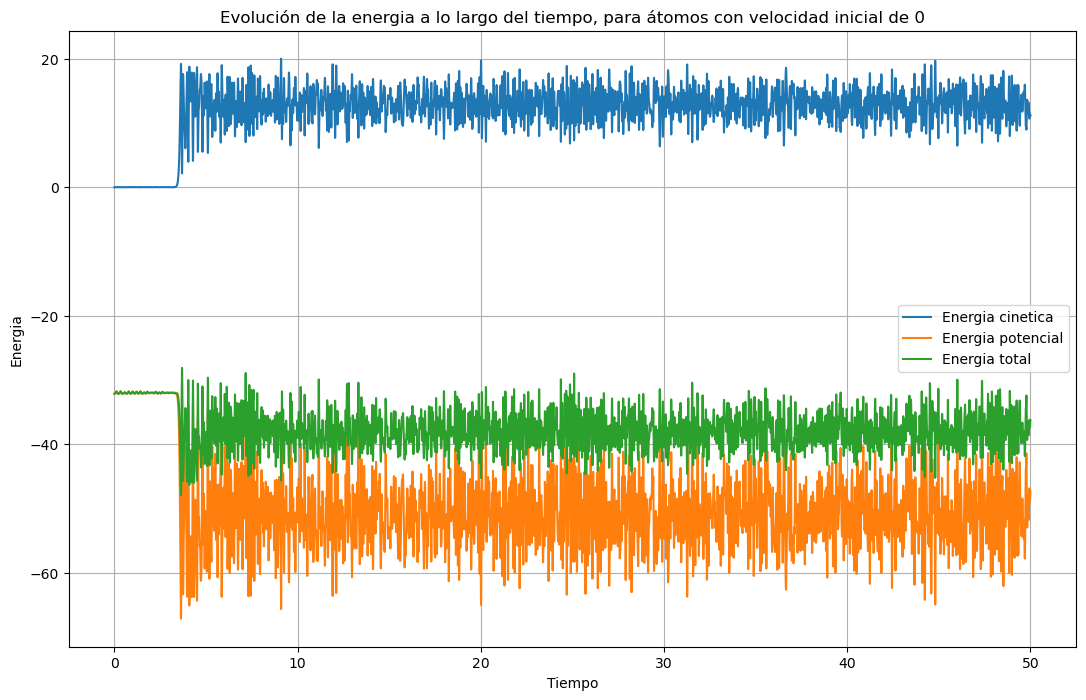

In [5]:
fig=plt.figure(figsize=(13,8)) #Size of the plot
ax=fig.add_subplot(111)

plt.plot(time, T, label="Energia cinetica")
plt.plot(time, V, label="Energia potencial")
plt.plot(time, T+V, label="Energia total")
plt.xlabel("Tiempo")
plt.ylabel("Energia")
plt.legend()
plt.title(f"Evolución de la energia a lo largo del tiempo, para átomos con velocidad inicial de {v_0}")
plt.grid()

plt.savefig(f"latex/plots/apartado_4_energia_{v_0}.png")

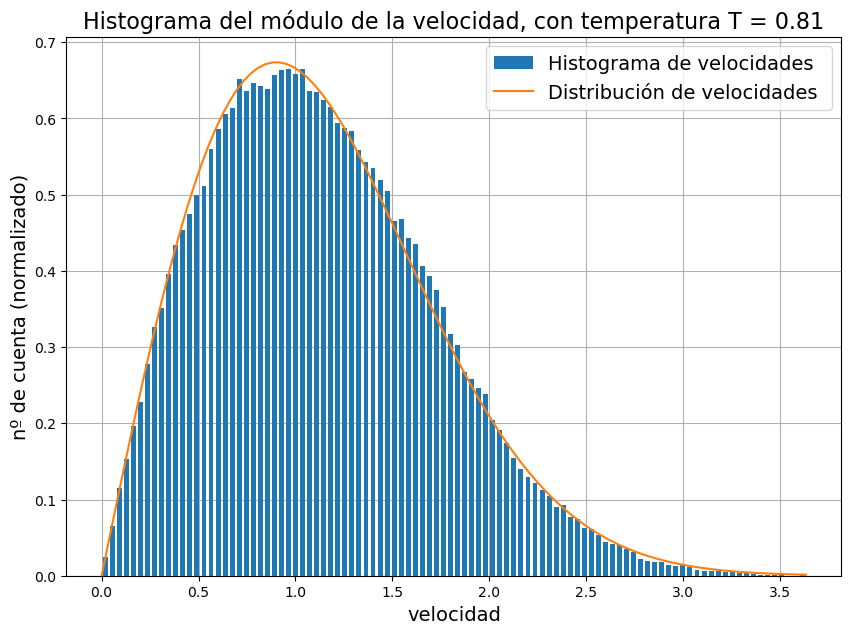

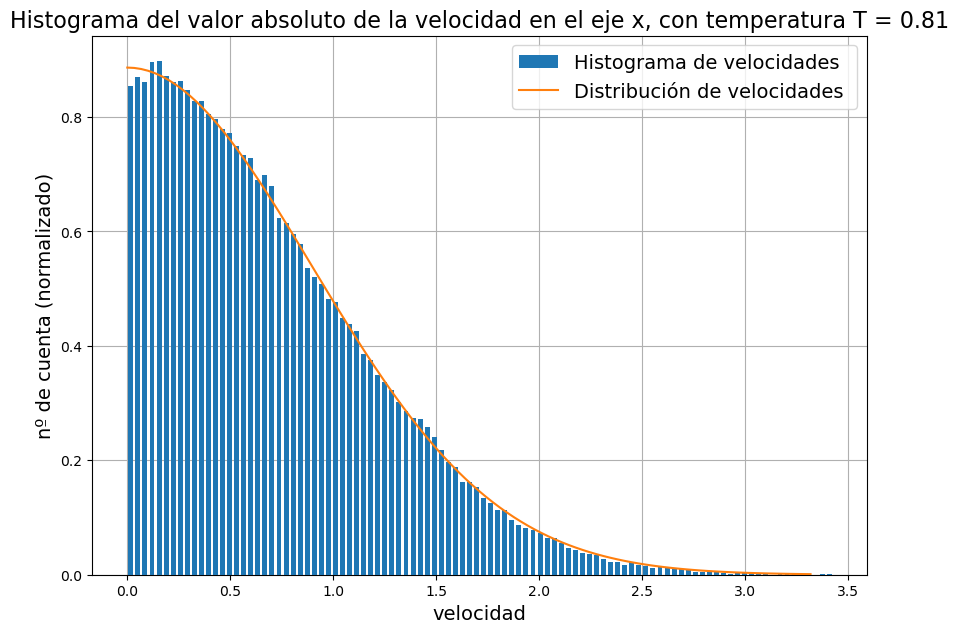

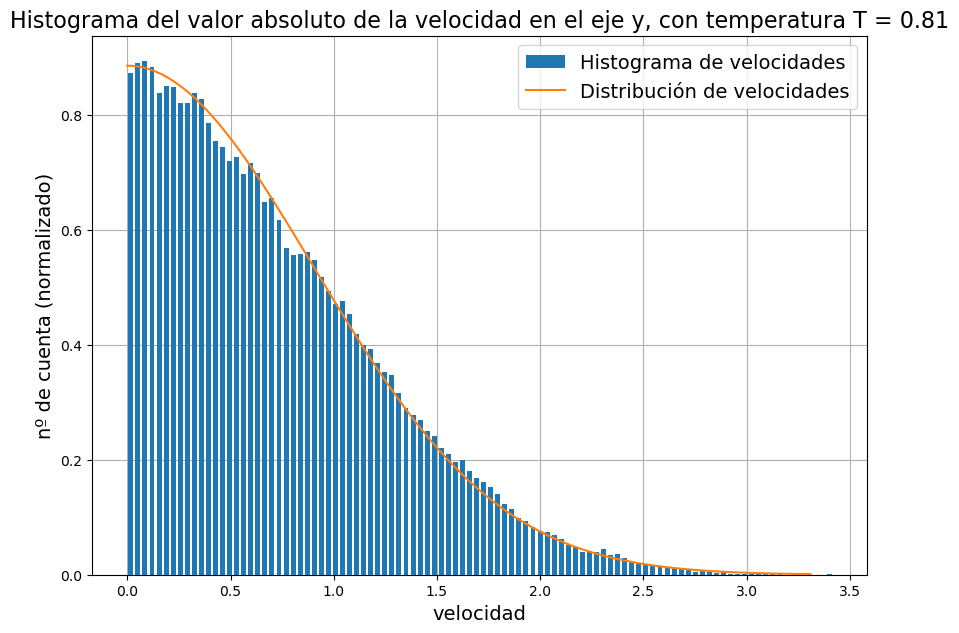

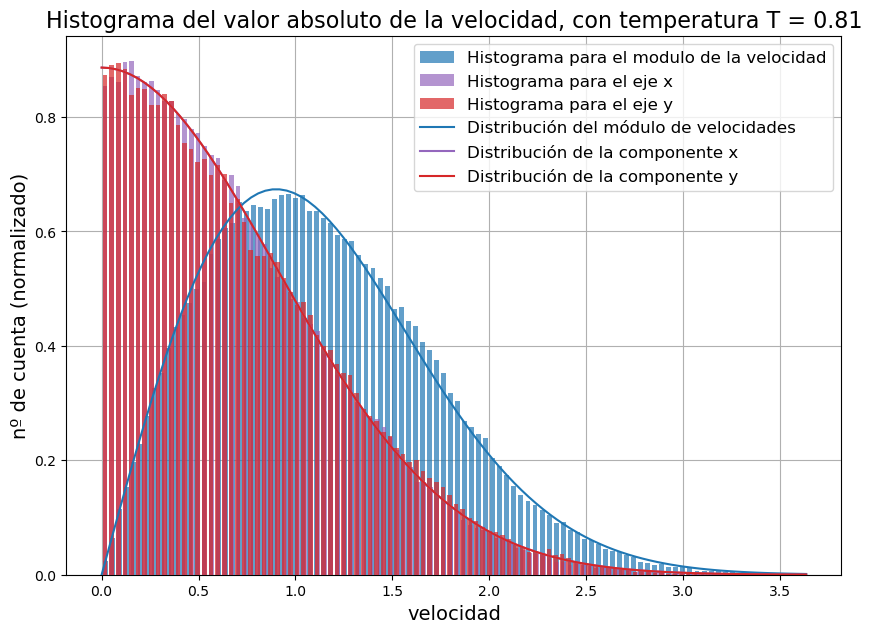

In [6]:
velocidad = pd.read_csv(f'datos_apartado_4/velocidades_{v_0}.txt', delimiter=',', index_col=False, header=0 ,names=['vx', 'vy', 'v'])

Temp = m/(2*k)*np.mean(velocidad.v**2)

def distribution_module (v):
    return (m/(k*Temp))*v*np.exp(-m*v*v/(2*k*Temp))

def distribution_velocity (v):
    return np.sqrt(2*m/(np.pi*k*Temp))*np.exp(-m*v*v/(2*k*Temp))

fig=plt.figure(figsize=(10,7)) 
ax=fig.add_subplot(111)
v = np.linspace(0, np.max(velocidad.v), 100)
plt.grid(zorder=0)
plt.hist(velocidad.v, bins=100 , rwidth=0.7, zorder = 3, density=True, label='Histograma de velocidades')
plt.plot(v, distribution_module(v), label=f'Distribución de velocidades ', zorder = 4)
plt.ylabel('nº de cuenta (normalizado)', fontsize=14)
plt.xlabel('velocidad', fontsize=14)
plt.legend(fontsize=14)
plt.title(f'Histograma del módulo de la velocidad, con temperatura T = {Temp:.2f}', fontsize=16)
plt.savefig(f"latex/plots/histograma_velocidad_modulo_{v_0}.png")

fig=plt.figure(figsize=(10,7)) 
ax=fig.add_subplot(111)
vx = np.linspace(0, np.max(velocidad.vx), 100)
plt.grid(zorder=0)
plt.hist(np.abs(velocidad.vx), bins=100 , rwidth=0.7, zorder = 3, density=True, label='Histograma de velocidades')
plt.plot(vx, distribution_velocity(vx), label=f'Distribución de velocidades ', zorder = 4)
plt.ylabel('nº de cuenta (normalizado)', fontsize=14)
plt.xlabel('velocidad', fontsize=14)
plt.legend(fontsize=14)
plt.title(f'Histograma del valor absoluto de la velocidad en el eje x, con temperatura T = {Temp:.2f}', fontsize=16)
plt.savefig(f"latex/plots/histograma_velocidad_x_{v_0}.png")

fig=plt.figure(figsize=(10,7)) 
ax=fig.add_subplot(111)
vy = np.linspace(0, np.max(velocidad.vy), 100)
plt.grid(zorder=0)
plt.hist(np.abs(velocidad.vy), bins=100 , rwidth=0.7, zorder = 3, density=True, label='Histograma de velocidades')
plt.plot(vy, distribution_velocity(vy), label=f'Distribución de velocidades', zorder = 4)
plt.ylabel('nº de cuenta (normalizado)', fontsize=14)
plt.xlabel('velocidad', fontsize=14)
plt.legend(fontsize=14)
plt.title(f'Histograma del valor absoluto de la velocidad en el eje y, con temperatura T = {Temp:.2f}', fontsize=16)
plt.savefig(f"latex/plots/histograma_velocidad_y_{v_0}.png")


fig=plt.figure(figsize=(10,7)) 
ax=fig.add_subplot(111)
v = np.linspace(0, np.max(velocidad.v), 100)
plt.grid(zorder=0)
plt.hist(velocidad.v, bins=100 , rwidth=0.7, zorder = 3, density=True, label='Histograma para el modulo de la velocidad', alpha=0.7, color='tab:blue')
plt.hist(np.abs(velocidad.vx), bins=100 , rwidth=0.7, zorder = 4, density=True, label='Histograma para el eje x', alpha=0.7, color='tab:purple')
plt.hist(np.abs(velocidad.vy), bins=100 , rwidth=0.7, zorder = 5, density=True, label='Histograma para el eje y', alpha=0.7, color='tab:red')

plt.plot(v, distribution_module(v), label=f'Distribución del módulo de velocidades ', zorder = 7, color='tab:blue')
plt.plot(v, distribution_velocity(v), label=f'Distribución de la componente x', zorder = 8, color='tab:purple')
plt.plot(v, distribution_velocity(v), label=f'Distribución de la componente y', zorder = 9, color='tab:red')

plt.ylabel('nº de cuenta (normalizado)', fontsize=14)
plt.xlabel('velocidad', fontsize=14)
plt.legend(fontsize=12)
plt.title(f'Histograma del valor absoluto de la velocidad, con temperatura T = {Temp:.2f}', fontsize=16)
plt.savefig(f"latex/plots/histograma_velocidad_{v_0}.png")

Repetimos el proceso pero variando la temperatura


In [7]:
f = open(f"datos_apartado_6/posiciones_{v_0}.txt", "w")
f_energia = open(f"datos_apartado_6/energias_{v_0}.txt", "w")
f_velocidad = open(f"datos_apartado_6/velocidades_{v_0}.txt", "w")

T, V = np.zeros(len(time)), np.zeros(len(time))

r, v = init_cond()
write_vector(r, f)
a, R = lennard_jones(r)
T[0], V[0] = compute_energy(v, R)
f_energia.write(f"{T[0]}, {V[0]}\n")

for i in range(1, len(time)):
    r, v, a, R = verlet_algorithm(r, v, a)
    T[i], V[i] = compute_energy(v, R)
    if (time[i]==20):
        v = v*1.5
    if (time[i]==30):
        v = v*1.5
    if (time[i]==35):
        v = v*1.5
    if (time[i]==45):
        v = v*1.5
    if (i%skip == 0):
        f.write(f"\n")
        write_vector(r, f)
    if(i >= int(20/h)):
        write_velocity(v, f_velocidad)
    f_energia.write(f"{T[i]}, {V[i]}\n")

f.close()
f_velocidad.close()
f_energia.close()

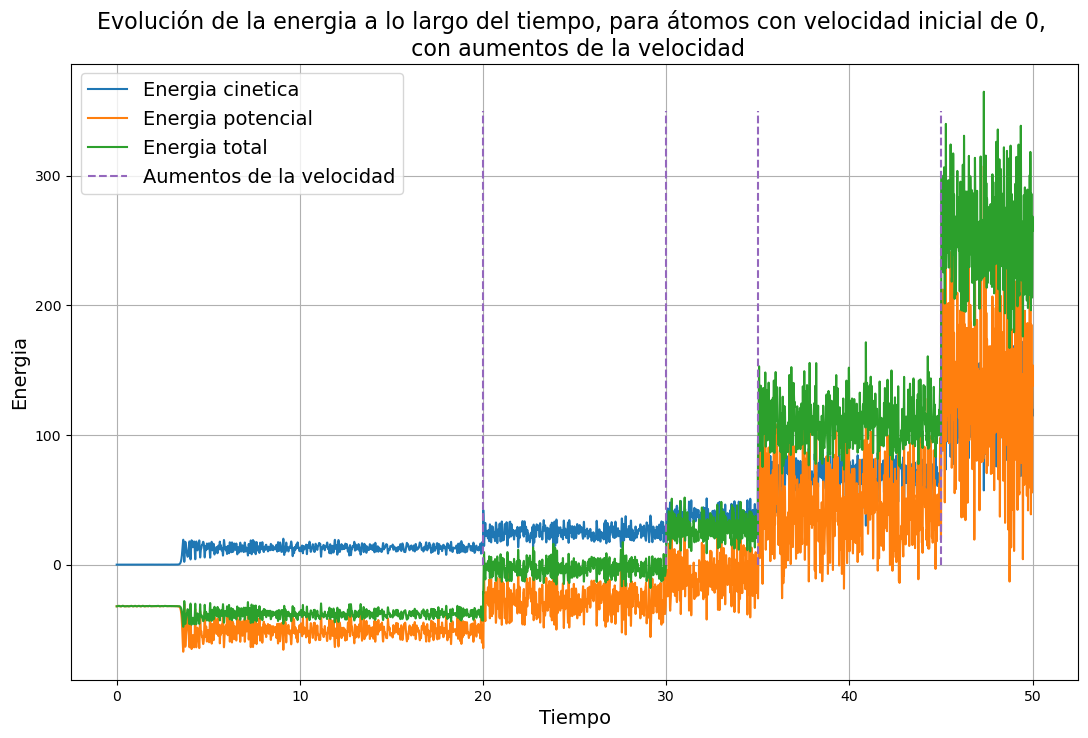

In [8]:
fig=plt.figure(figsize=(13,8)) #Size of the plot
ax=fig.add_subplot(111)

plt.plot(time, T, label="Energia cinetica")
plt.plot(time, V, label="Energia potencial")
plt.plot(time, T+V, label="Energia total")
plt.vlines(20, 0, 350, color='tab:purple', linestyle='--', label='Aumentos de la velocidad')
plt.vlines(30, 0, 350, color='tab:purple', linestyle='--')
plt.vlines(35, 0, 350, color='tab:purple', linestyle='--')
plt.vlines(45, 0, 350, color='tab:purple', linestyle='--')
plt.xlabel("Tiempo", fontsize=14)
plt.ylabel("Energia", fontsize=14)
plt.legend(fontsize=14)
plt.title(f"Evolución de la energia a lo largo del tiempo, para átomos con velocidad inicial de {v_0}, \n con aumentos de la velocidad", fontsize=16)
plt.grid()

plt.savefig(f"latex/plots/apartado_6_energia_{v_0}.png", bbox_inches='tight', pad_inches=0.1)

Para obtener los desplazamientos cuadrático medio de las partículas, volveremos a leer el archivo creado de las posiciones de las partículas. Para ello emplearemos el código de la animación de los planetas.

In [9]:
file_in = f"datos_apartado_6/posiciones_{v_0}.txt"

# Lectura del fichero de datos
# ========================================
# Lee el fichero a una cadena de texto
with open(file_in, "r") as f:
    data_str = f.read()

# Inicializa la lista con los datos de cada fotograma.
# frames_data[j] contiene los datos del fotograma j-ésimo
frames_data = list()

# Itera sobre los bloques de texto separados por líneas vacías
# (cada bloque corresponde a un instante de tiempo)
for frame_data_str in data_str.split("\n\n"):
    # Inicializa la lista con la posición de cada planeta
    frame_data = list()

    # Itera sobre las líneas del bloque
    # (cada línea da la posición de un planta)
    for planet_pos_str in frame_data_str.split("\n"):
        # Lee la componente x e y de la línea
        planet_pos = np.fromstring(planet_pos_str, sep=",")
        # Si la línea no está vacía, añade planet_pos a la lista de 
        # posiciones del fotograma
        if planet_pos.size > 0:
            frame_data.append(np.fromstring(planet_pos_str, sep=","))

    # Añade los datos de este fotograma a la lista
    frames_data.append(frame_data)

data = np.array(frames_data)


Mediremos el desplazamiento medio cada cierto tiempo para la partícula 0

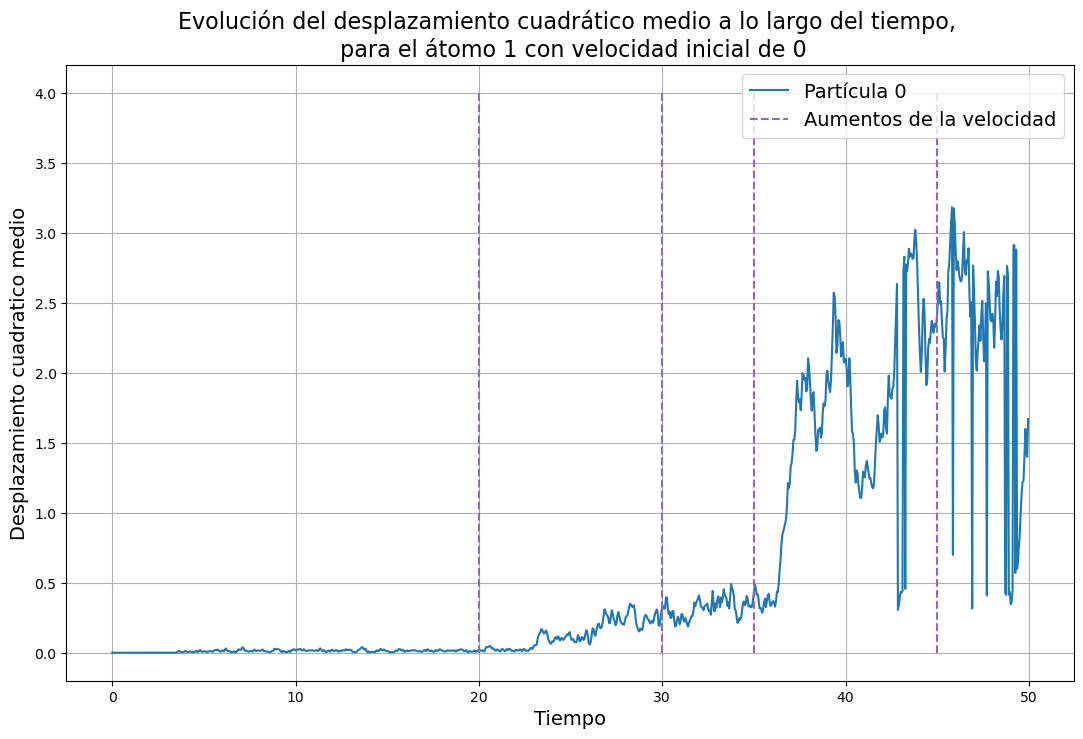

In [16]:
time_between_measurement = 0.05
desplazamiento = np.zeros(int(Time/time_between_measurement))
n = int(len(data[:,0])/len(desplazamiento))
for i in range (len(desplazamiento)):
    desplazamiento[i] = compute_mean_square_displacement(data[:,0][i*n:(i+1)*n], data[:,0][0])

fig=plt.figure(figsize=(13,8))
ax=fig.add_subplot(111)

time_steps = np.arange(0, Time, time_between_measurement)

plt.plot(time_steps, desplazamiento, label="Partícula 0")
plt.vlines(20, 0, 4, color='tab:purple', linestyle='--', label='Aumentos de la velocidad')
plt.vlines(30, 0, 4, color='tab:purple', linestyle='--')
plt.vlines(35, 0, 4, color='tab:purple', linestyle='--')
plt.vlines(45, 0, 4, color='tab:purple', linestyle='--')
plt.xlabel("Tiempo", fontsize=14)
plt.ylabel("Desplazamiento cuadratico medio", fontsize=14)
plt.legend(fontsize=14)
plt.title("Evolución del desplazamiento cuadrático medio a lo largo del tiempo, \n para el átomo 1 con velocidad inicial de 0", fontsize=16)
plt.grid()

plt.savefig(f"latex/plots/desplazamiento_1_particula.png", bbox_inches='tight', pad_inches=0.1)
